# UCI Bank Marketing Dataset - Solução

# INTRODUÇÃO
## Importando bibliotecas

In [1079]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
from scipy import stats
from sklearn import linear_model

## Carregando a base e criando um dataframe

In [755]:
#Carregar a base e visualizar primeiras linhas
filepath = '...\\bank-full.csv' #deve ser preenchido com o caminho onde se encontra a base.
df = pd.read_csv(filepath, 
                  sep=';', 
                  header=0)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


---

# QUESTÃO 1
## 1. Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?
### 1.1 Modelando o problema
Aqui, a ideia é verificar a proporção de empréstimos por cada profissão.
Portanto, serão usadas os seguintes atributos:
* *job* (profissões)
* *housing* (empréstimos imobiliários)
* *loan* (empréstimos pessoais)

### 1.2 Gerando o dataframe da questão

In [1120]:
df1 = df[['job','housing','loan']]
df1.head()

,job,housing,loan
0,management,yes,no
1,technician,yes,no
2,entrepreneur,yes,yes
3,blue-collar,yes,no
4,unknown,no,no


### 1.3 Convertendo *housing* e *loan* em binário (0/1)

In [1121]:
#!pip install category_encoders #descomentar início da linha caso não tenha instalado
import category_encoders as ce
encoder = ce.BinaryEncoder()
df1_binary = encoder.fit_transform(df1.loc[:,['housing','loan']])
df1_binary.head()

,housing_0,housing_1,loan_0,loan_1
0,0,1,0,1
1,0,1,0,1
2,0,1,1,0
3,0,1,0,1
4,1,0,0,1


Nota-se que os campos que tem valor 1 para *yes* e 0 para *no* são ***housing_1*** e ***loan_0***.

Então, esses foram escolhidos para unir com ***job*** e depois foram renomeadas.

In [1124]:
#União com a coluna job
df1 = pd.concat([df1.loc[:,['job']], df1_binary.loc[:,['housing_1', 'loan_0']]], axis=1).reindex()

#Renomeando para "housing" e "loan"
df1.rename(columns={'housing_1':'housing','loan_0':'loan'},inplace=True)

#Criando coluna "any" informando se pegou um empréstimo, independente do tipo
#Não se trata de uma soma, mas sim de uma verificação se foi feito ou não
df1['any'] = df1.max(axis=1)
df1.head()

,job,housing,loan,any
0,management,1,0,1
1,technician,1,0,1
2,entrepreneur,1,1,1
3,blue-collar,1,0,1
4,unknown,0,0,0


### 1.4 Calculando a proporção de empréstimos por profissão

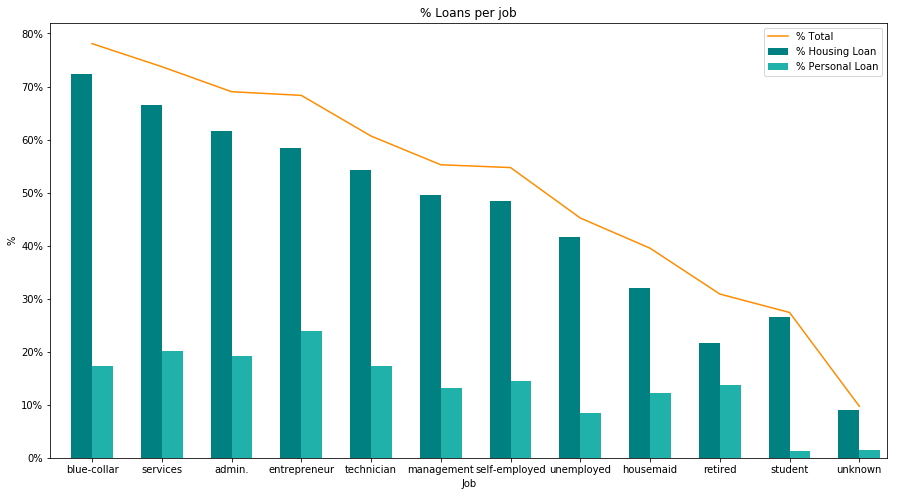

,housing_rate,loan_rate,total_rate
job,,,
blue-collar,72.4%,17.3%,78.1%
services,66.6%,20.1%,73.7%
admin.,61.5%,19.2%,69.0%
entrepreneur,58.4%,23.9%,68.3%
technician,54.2%,17.2%,60.7%
management,49.5%,13.2%,55.2%
self-employed,48.4%,14.5%,54.7%
unemployed,41.7%,8.4%,45.2%
housemaid,32.1%,12.3%,39.5%


In [1168]:
#Quantidade de empréstimos realizados por profissão
df1_yes = df1.groupby('job').sum()

#Total de clientes por profissão
df1_total = pd.DataFrame({'any':list()})
df1_total = df1.groupby('job').count()
df1_total['total'] = df1_total.max(axis=1)
df1_total = df1_total[['total']]

#Unindo as tabelas
df1_total= pd.concat([df1_yes, df1_total.loc[:,['total']]], axis=1).reindex()

#Criando colunas com a proporção de empréstimos/clientes
df1_total['housing_rate'] = df1_total['housing']/df1_total['total']
df1_total['loan_rate'] = df1_total['loan']/df1_total['total']
df1_total['total_rate'] = df1_total['any']/df1_total['total']
#Obs.: O campo total_rate significa a proporção geral, considerando empréstimos imobiliários e pessoais.

#Organizando a tabela com as proporções
df1_total = df1_total[['housing_rate','loan_rate','total_rate']]

#Ordenando do maior pro menor "total_rate"
df1_total = df1_total.sort_values(by=['total_rate'], ascending=False)

#Plotando o gráfico
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick

width = .6 #largura da barra

df1_plot = 100*df1_total
df1_plot[['housing_rate','loan_rate']].plot(kind='bar', width = width, color=['teal','lightseagreen'])
df1_plot['total_rate'].plot(secondary_y=False, color=['darkorange'])

ax = plt.gca()
plt.xlim([-width, len(df1_plot['total_rate'])-width])

plt.ticklabel_format(axis='y', style='plain', scilimits=(0, 1))
plt.title('% Loans per job')
plt.xlabel('Job')
plt.ylabel('%')

fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

fig_size = [15,8]
plt.rcParams["figure.figsize"] = fig_size
plt.legend(['% Total', '% Housing Loan', '% Personal Loan'], loc=0)
plt.show()

#Formatando o dataframe para percentual
df1_total['housing_rate'] = pd.Series(["{0:.1%}".format(val) for val in df1_total['housing_rate']], index = df1_total.index)
df1_total['loan_rate'] = pd.Series(["{0:.1%}".format(val) for val in df1_total['loan_rate']], index = df1_total.index)
df1_total['total_rate'] = pd.Series(["{0:.1%}".format(val) for val in df1_total['total_rate']], index = df1_total.index)

df1_total

#O campo total_rate significa a proporção geral, considerando empréstimos imobiliários e pessoais.

### 1.5 Resposta 1

A profissão com maior tendência a fazer um empréstimo é ***BLUE-COLLAR***  
*(78,1% dos clientes com esta profissão fizeram algum tipo de empréstimo)*.

Esta profissão é também a que tem maior taxa de empréstimos imobiliários   
*(72,4% dos clientes com esta profissão fizeram um empréstimo imobiliário)*.  
Portanto, o tipo é **imobiliário *(HOUSING)***.

---

# QUESTÃO 2
## 2. Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?

### 2.1 Modelando o problema
As variáveis analisadas são:
* *campaign* (número de contatos)
* *y* (resultado da campanha)  

### 2.2 Gerando o dataframe da questão

In [677]:
df2 = df[['campaign','y']]
df2.head()

,campaign,y
0,1,no
1,1,no
2,1,no
3,1,no
4,1,no


### 2.3 Testando comportamento de *y*
Deve-se observar a quantidade de sucessos por quantidade de ligações.  
Primeiro, deve-se obter a quantidade a quantidade total de y = yes (success).  
Por fim, calcular a taxa de sucesso (sucesso/total).

In [678]:
#Obter o total de "y"
df2_total = df2
df2_total = df2_total.groupby('campaign').count()
df2_total = df2_total.loc[:, ['y']]
df2_total.rename(columns={'y':'total'},inplace=True)

#Filtrando "y" com valor "yes"
df2_success = df2.loc[df['y'] == 'yes']

df2_success = df2_success.groupby('campaign').count()
df2_success = df2_success.loc[:, ['y']]
df2_success.rename(columns={'y':'success'}, inplace=True)

#Unindo as tabelas
df2 = pd.concat([df2_total, df2_success.loc[:,['success']]], axis=1).reindex()
df2.fillna(0, inplace=True)
df2 = df2.astype('int32')

#Calculando taxa de sucesso
df2['success_rate'] = df2['success']/df2['total']

#Calculando valores acumulados
df2['total_acc'] = df2['total'].cumsum()
df2['success_acc'] = df2['success'].cumsum()
df2['rate_acc'] = df2['success_acc']/df2['total_acc']
df2['success_perc'] = df2['success']/df2['success'].sum()
df2['success_perc_acc'] = df2['success_acc']/df2['success'].sum()
df2.head(10)

,total,success,success_rate,total_acc,success_acc,rate_acc,success_perc,success_perc_acc
campaign,,,,,,,,
1,17544,2561,0.145976,17544,2561,0.145976,0.484213,0.484213
2,12505,1401,0.112035,30049,3962,0.131851,0.264889,0.749102
3,5521,618,0.111936,35570,4580,0.128760,0.116846,0.865948
4,3522,317,0.090006,39092,4897,0.125269,0.059936,0.925884
5,1764,139,0.078798,40856,5036,0.123262,0.026281,0.952165
6,1291,92,0.071263,42147,5128,0.121669,0.017395,0.969559
7,735,47,0.063946,42882,5175,0.120680,0.008886,0.978446
8,540,32,0.059259,43422,5207,0.119916,0.006050,0.984496
9,327,21,0.064220,43749,5228,0.119500,0.003971,0.988467


### 2.4 Resposta 2
É importante observar:
* Total de ligações = 124.956;
* Total de casos de sucesso = 5.289;
* A taxa de sucesso (*success_rate*) tende a ser maior com menos ligações: **14,60%** com **uma** ligação, **11,20%** com **duas**, **11,19%** com **três** etc.
* 48% dos casos de sucesso tiveram apenas uma ligação.
* 75% dos casos de sucesso tiveram até duas ligações.

--- 

# QUESTÃO 3
## 3. Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão?

### 3.1 Número médio
Uma medida interessante é o valor da **mediana**, filtrando apenas os casos de sucesso.

In [738]:
df3_test = df[['campaign','y']]
df3_test = df3_test.loc[df['y'] == 'yes']
df3_test['campaign'].median()

2.0

### 3.2 Número máximo

In [1165]:
df3_max = df2[['success_perc_acc']]
df3_max.loc[:,['success_perc_acc']] \
               = pd.Series(["{0:.1%}".format(val) for val in df3_max['success_perc_acc']], index = df3.index)
df3_max.head(10)

,success_perc_acc
campaign,
1,48.4%
2,74.9%
3,86.6%
4,92.6%
5,95.2%
6,97.0%
7,97.8%
8,98.4%
9,98.8%


Com até três ligações, houve sucesso em 86,6% dos casos. Esse número chega a 95,2% com até cinco ligações.  
Não havendo informações sobre custo das ligações e retorno com a conversão, essa definição pode ser um pouco arbitrária.  
  
Por exemplo, se as ligações forem muito baratas e o retorno muito alto, pode valer a pena fazer muitas ligações.  
Por outro lado, se a relação for oposta, com recursos limitados, torna-se mais indicado fazer poucas ligações. 

Em um ambiente equilibrado, uma medida comumente utilizada é de 95%.
Com isso, o número máximo seria de 5 ligações.

### 3.3 Resposta 3
* Número médio = **2** ligações.
* Número máximo = **5** ligações.
  
---

# QUESTÃO 4
## 4. O resultado da campanha anterior tem relevância na campanha atual?

### 4.1 Modelando o problema
Deve ser feito um teste de hipóteses para avaliar a significância do resultado da campanha anterior
* Hipótese 0 (H0): a campanha anterior **não tem** relevância na campanha atual
* Hipótese 1 (H1): a campanha anterior **tem** relevância na campanha atual

### 4.2 Gerando o dataframe da questão

In [809]:
df4 = df[['poutcome','y']]
df4.head(10)

,poutcome,y
0,unknown,no
1,unknown,no
2,unknown,no
3,unknown,no
4,unknown,no
5,unknown,no
6,unknown,no
7,unknown,no
8,unknown,no
9,unknown,no


### 4.3 Comparando os cenários 

Observa-se que existem bastantes valores *unknown* em *poutcome*.  
Quando *poutcome* = *unknown*, significa que o cliente não participou da ação anterior.

Vamos então analisar os dois cenários:
* *poutcome* != *unknown*
* *poutcome* == *unknown*  

In [861]:
#Contagem geral de valores
total_count = df4['poutcome'].count()

#Filtrando "poutcome" com valor diferente de "unknown"
known_count = df4['poutcome'].loc[df['poutcome'] != 'unknown'].count()

#Proporção com valor diferente de "unknown"
known_rate = known_count/total_count

'{:.1%}'.format(known_rate)

#Gerando quantidade de "unknown" por valor de "previous"
#df4_unknown = df4_unknown.groupby('previous').count()
#df4_unknown = df4_unknown.loc[:, ['poutcome']]
#df4_unknown

'18.3%'

Em apenas 18,3% dos casos, o resultado da campanha anterior é conhecido.

#### 4.3.1 Resultado anterior é conhecido

In [811]:
#Filtrando o dataset para diferente de "unknown"
df4_known = df4.loc[df['poutcome'] != 'unknown']

#Transformando em binário
encoder = ce.BinaryEncoder()
df4_kbin = encoder.fit_transform(df4_known)

#Juntando para verificar o significado
df4_kverif = pd.concat([df4_known, df4_kbin], axis=1).reindex()
df4_kverif.head(10)

,poutcome,y,poutcome_0,poutcome_1,poutcome_2,y_0,y_1
24060,failure,no,0,0,1,0,1
24062,other,yes,0,1,0,1,0
24064,failure,yes,0,0,1,1,0
24072,other,no,0,1,0,0,1
24077,failure,yes,0,0,1,1,0
24080,success,yes,0,1,1,1,0
24086,other,no,0,1,0,0,1
24122,other,no,0,1,0,0,1
24127,failure,no,0,0,1,0,1
24136,other,no,0,1,0,0,1


In [820]:
#Quando "poutcome" = "success", poutcome_1 e poutcome_2 são iguais a 1 simultaneamente
#Com isso, a poutcome_0 foi reconstruída a partir delas.
df4_kverif['poutcome_0'] = df4_kverif['poutcome_1'] + df4_kverif['poutcome_2'] - 1
#Assim, quando for "success", o valor será 1. Caso contrário, 0.

#Escolhidas as colunas para representar de forma binária
df4_ktotal = df4_kverif[['poutcome_0','y_0']]
df4_ktotal.rename(columns={'poutcome_0':'poutcome','y_0':'deposit'},inplace=True)
df4_ktotal.head(10)

,poutcome,deposit
24060,0,0
24062,0,1
24064,0,1
24072,0,0
24077,0,1
24080,1,1
24086,0,0
24122,0,0
24127,0,0
24136,0,0


In [841]:
#Criando uma coluna "keep" indicando se o resultado foi mantido ou não (1=mantido, 0=não mantido)
df4_ktotal['keep'] = abs(abs(df4_ktotal['deposit'] - df4_ktotal['poutcome'])-1)
df4_ktotal.head(10)

C:\Users\leandro.capela\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,poutcome,deposit,keep
24060,0,0,1
24062,0,1,0
24064,0,1,0
24072,0,0,1
24077,0,1,0
24080,1,1,1
24086,0,0,1
24122,0,0,1
24127,0,0,1
24136,0,0,1


In [867]:
df4_ktotal.describe()

,poutcome,deposit,keep
count,8252.000000,8252.000000,8252.000000
mean,0.183107,0.230611,0.823316
std,0.386778,0.421249,0.381425
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


Observam-se alguns pontos.  
A **média** de cada campo indica a proporção de cada um deles. Ou seja:
* Em 82,3% dos casos, o resultado foi mantido. É um bom indício, mas ainda não é suficiente.
* Em **23,1%** dos casos, houve sucesso na campanha atual. Esta média será testada.
* Em 18,3% dos casos, houve sucesso na campanha anterior.

#### 4.3.2 Resultado anterior não é conhecido 

In [904]:
#Filtrando o dataset para "unknown"
df4_unknown = df4.loc[df['poutcome'] == 'unknown']

#Transformando em binário
encoder = ce.BinaryEncoder()
df4_ubin = encoder.fit_transform(df4_unknown)

#Juntando para verificar o significado
df4_uverif = pd.concat([df4_unknown, df4_ubin], axis=1).reindex()
df4_uverif.head(10)

,poutcome,y,poutcome_0,y_0,y_1
0,unknown,no,1,0,1
1,unknown,no,1,0,1
2,unknown,no,1,0,1
3,unknown,no,1,0,1
4,unknown,no,1,0,1
5,unknown,no,1,0,1
6,unknown,no,1,0,1
7,unknown,no,1,0,1
8,unknown,no,1,0,1
9,unknown,no,1,0,1


In [875]:
#Obtendo as estatísticas com resultado não conhecido
df4_utotal = df4_uverif[['y_0']]
df4_utotal.describe()

,y_0
count,36959.000000
mean,0.091615
std,0.288486
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


A taxa de sucesso nesse caso é de apenas **9,1%**.

Agora vamos testar as hipóteses.

#### 4.3.3 Teste de hipóteses

Relembrando:
* Hipótese 0 (H0): a campanha anterior **não tem** relevância na campanha atual (as médias são iguais)
* Hipótese 1 (H1): a campanha anterior **tem** relevância na campanha atual (as médias são diferentes)



In [897]:
#Teste t para duas médias

#Resultado conhecido
n_k = df4_ktotal['deposit'].count() # n = tamanho da amostra
mean_k = df4_ktotal['deposit'].mean() # média
var_k = df4_ktotal['deposit'].std()**2 # variância

#Resultado não conhecido
n_u = df4_utotal['y_0'].count() # n = tamanho da amostra
mean_u = df4_utotal['y_0'].mean() # média
var_u = df4_utotal['y_0'].std()**2 # variância

#Graus de liberdade
dof = n_k + n_u - 2

#Estimador da variãncia
s_sq = ((n_k-1)*var_k + (n_u-1)*var_u) / (n_k + n_u - 2)

#Estatística de teste (t)
t = (mean_k + mean_u) / m.sqrt(s_sq * (1/n_k + 1/n_u))

#p-valor
p = 1 - stats.t.cdf(t,df=dof)

print("t = " + str(t))
print("p = " + str(2*p))
print("g.l. = " + str(dof))

t = 83.51517443274929
p = 0.0
g.l. = 45209


### 4.4 Resposta 4
Testando nível de significância = 5%.  
Pela quantidade de graus de liberdade (45.209) e o valor de t (83,5), pode-se **rejeitar H0**, com 95% de confiança.  
  
Testando outros valores de significância (até 0,05%):  
Pode-se inclusive rejeitar H0 com um intervalo de confiança maior, de 99,95%, por exemplo, já que o valor de *t* e a quantidade de graus de liberdade são altos o suficiente para isso.  

O *p-valor* de 0,0 reforça a afirmação.  

Com isso, podemos afirmar, com **99,95% de confiança**, que o resultado da campanha anterior **tem relevância** na campanha atual.

---

# QUESTÃO 6
## 6. Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?

### 6.1 Modelando o problema
Será analisada a variável ***housing***. 
As possíveis características são:
* *age* (idade)
* *job* (profissão)
* *marital* (estado civil)
* *education* (escolaridade)
* *default* (possui crédito vencido)
* *balance* (saldo bancário médio anual)
* *loan* (possui empréstimo pessoal)

### 6.2 Criando o dataframe

In [991]:
df6 = df[['age', 
          'job', 
          'marital', 
          'education', 
          'default', 
          'balance', 
          'loan',
          'housing']]
df6.head()

,age,job,marital,education,default,balance,loan,housing
0,58,management,married,tertiary,no,2143,no,yes
1,44,technician,single,secondary,no,29,no,yes
2,33,entrepreneur,married,secondary,no,2,yes,yes
3,47,blue-collar,married,unknown,no,1506,no,yes
4,33,unknown,single,unknown,no,1,no,no


### 6.3 Transformando variáveis categóricas em binárias

Entre as sete características, temos:  
  
* Numéricas (não precisam de tratamento inicial)  
    - *age* (idade)
    - *balance* (saldo bancário médio anual)
  
  
* Categóricas binárias
     - *default* (possui crédito vencido)
     - *loan* (possui empréstimo pessoal)
  
  
* Múltiplas categorias
    - *job* (profissão)
    - *marital* (estado civil)
    - *education* (escolaridade)
    


In [1059]:
df6_total = pd.get_dummies(df6, columns=['job', 
                                        'marital', 
                                        'education', 
                                        'default', 
                                        'loan', 
                                        'housing'])

#Removendo colunas que não trazem informação nova
df6_total = df6_total.drop(['default_no',
                            'loan_no',
                            'housing_no',
                            'job_unknown',
                            'education_unknown'], axis=1)

#Renomeando colunas para nomes mais simples
df6_total.rename(columns={'default_yes':'default','loan_yes':'loan','housing_yes':'housing'},inplace=True)

#Mostrar estatísticas
df6_total.describe()

,age,balance,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,default,loan,housing
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.00000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,0.114375,0.215257,0.032890,0.027427,0.209197,0.050076,0.034925,0.09188,0.020747,0.168034,0.028820,0.115171,0.601933,0.282896,0.151534,0.513194,0.294198,0.018027,0.160226,0.555838
std,10.618762,3044.765829,0.318269,0.411005,0.178351,0.163326,0.406740,0.218105,0.183592,0.28886,0.142538,0.373901,0.167303,0.319232,0.489505,0.450411,0.358572,0.499831,0.455687,0.133049,0.366820,0.496878
min,18.000000,-8019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,448.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,1428.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,95.000000,102127.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 6.4 Normalização
Das 24 variáveis restantes, 22 estão com valores entre 0 e 1.  
No entanto, há duas que precisam ser normalizadas: 
* *age*
* *balance*

In [1060]:
#Normalização de "age"
df6_total['age_norm'] = \
(df6_total['age'] -  df6_total['age'].min()) / (df6_total['age'].max() - df6_total['age'].min())

#Normalização de "balance"
df6_total['balance_norm'] = \
(df6_total['balance'] -  df6_total['balance'].min()) / (df6_total['balance'].max() - df6_total['balance'].min())

df6_total = df6_total.drop(['age', 'balance'], axis=1)

#Organizando o dataframe para "housing" ficar no final
cols = df6_total.columns.tolist()
cols = cols[:-3] + cols[-2:] + cols[-3:-2]
df6_total = df6_total[cols]

#Mostrar estatísticas
df6_total.describe()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,default,loan,age_norm,balance_norm,housing
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.00000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,0.114375,0.215257,0.032890,0.027427,0.209197,0.050076,0.034925,0.09188,0.020747,0.168034,0.028820,0.115171,0.601933,0.282896,0.151534,0.513194,0.294198,0.018027,0.160226,0.297873,0.085171,0.555838
std,0.318269,0.411005,0.178351,0.163326,0.406740,0.218105,0.183592,0.28886,0.142538,0.373901,0.167303,0.319232,0.489505,0.450411,0.358572,0.499831,0.455687,0.133049,0.366820,0.137906,0.027643,0.496878
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194805,0.073457,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.272727,0.076871,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.389610,0.085768,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Agora, com a normalização feita, podemos analisar as variáveis.

### 6.5 Filtro Wrapper

In [1095]:
#Importando pacotes
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#Carregando dados
array = df6_total.values
X = array[:,0:-1]
Y = array[:,-1]

#Extraindo atributos
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

C:\Users\leandro.capela\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Num Features: 3
Selected Features: [False  True False False False False False False False False False False
 False False False False False False False  True  True]
Feature Ranking: [ 3  1  4  9  6 10  7  2 15  5  8 16 18 11 14 13 19 12 17  1  1]


Ao selecionar os três principais atributos, foram apontados os das posições [1], [-2] e [-1].  
Ou seja, no dataframe ocupam as posições [1], [-3] e [-2] devido ao *housing* na última coluna.

  

In [1119]:
print(df6_total.columns[1])
print(df6_total.columns[-3])
print(df6_total.columns[-2])

job_blue-collar
age_norm
balance_norm


### 6.6 Resposta 6
Os atributos mais relevantes são:
* *job_blue-collar*
* *age*
* *balance*
---

# QUESTÃO 5
## 5. Qual o fator determinante para que o banco exija um seguro de crédito?

Normalmente, os bancos exigem seguro de crédito quando o cliente está inadimplente.  
Ou seja, o atributo a ser analisado é ***default*** (possui crédito vencido).  

Obs.: Vale o registro que a questão 6 foi resolvida antes da questão 5. Com isso, parte de sua solução será aproveitada nesta questão.

### 5.1 Organizando o dataframe

In [1103]:
df5 = df6_total

#Organizando o dataframe para "default" ficar no final
cols5 = df5.columns.tolist()
cols5 = cols5[:-5] + cols5[-4:] + cols5[-5:-4]
df5 = df5[cols5]

#Mostrar estatísticas
df5.describe()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,loan,age_norm,balance_norm,housing,default
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.00000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,0.114375,0.215257,0.032890,0.027427,0.209197,0.050076,0.034925,0.09188,0.020747,0.168034,0.028820,0.115171,0.601933,0.282896,0.151534,0.513194,0.294198,0.160226,0.297873,0.085171,0.555838,0.018027
std,0.318269,0.411005,0.178351,0.163326,0.406740,0.218105,0.183592,0.28886,0.142538,0.373901,0.167303,0.319232,0.489505,0.450411,0.358572,0.499831,0.455687,0.366820,0.137906,0.027643,0.496878,0.133049
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194805,0.073457,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.272727,0.076871,1.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.389610,0.085768,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 5.2 Gerando o Wrapper

In [1105]:
#Carregando dados
array = df5.values
X = array[:,0:-1]
Y = array[:,-1]

#Extraindo atributos
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 1)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 1
Selected Features: [False False False False False False False False False False False False
 False False False False False False False  True False]
Feature Ranking: [11 13  5 14  8 20  9 21  2 16  6 10 15 19 17 18  7  3  4  1 12]


Ao selecionar o atributo determinante, foi selecionado o de posição [-2] entre os atributos. Ou seja, o de posição [-3] no dataframe.

In [1116]:
df5.columns[-3]

'balance_norm'

### 5.3 Resposta 5  
O fator determinante para *default* é ***balance***.

---